<font size=6>
    <b>Cross_check_datapoints.ipynb:</b> Train an ensemble of lower accuracy models, then use them to find inaccurate labels in the ewt conll dataset. 
 </font>

# Introduction

This document is currently a Work in Progress. The goal is to do something similar to conll_3.ipynb, where an ensemble of models are used together to find possible incorrect labels in the orignal corpus. 
There are three main phases: 

### 1. Preprocessing

The preprocessing phase uses many of the integrations for Text-extensions for Pandas to prep the dataset for training and inferencing on ahead of susspicious enry flagging 
Broadly, what we do is: 
1. Import all the folds of the dataset we're using (Universal dependencies EWT) 
1. Create a Pandas Categorical datatype on over which to classify
1. Retokenize that dataset using Huggingface Transformers to Bert-compatible tokens
1. Correlate the new tokens with their original counterpart's parts of speech
1. Create the Bert embeddings for each sub-token
1. Convert the parts of speech tags to our categoical datatype

### 2. Model Training 
   
During the model training phase, we train a number of models ontop of the bert embeddings ontop of the Bert embeddings we calculated in phase one 
These fall into two categories: 
- a large model accross the whole Bert embedding space with relatively high accuracy
- a large number of lower accuracy models trained on gaussian random projections of the Bert embedding space

### 3. Cross-correlation

In this phase, we run inference on the corpus and, using the models in conjunction look for places where there is high agreement between models that disagrees with the corpus ground truth label, flag suspicious entries and go through some descriptive stats. 


In [36]:
import os
import sys
import numpy as np
import pandas as pd
import transformers
import sklearn

import sklearn.pipeline
import multiprocessing
import pickle

import matplotlib.pyplot as plt
import ipywidgets
import util

# And of course we need the text_extensions_for_pandas library itself.
try:
    import text_extensions_for_pandas as tp
except ModuleNotFoundError as e:
    # If we're running from within the project source tree and the parent Python
    # environment doesn't have the text_extensions_for_pandas package, use the
    # version in the local source tree.
    if "../.." not in sys.path:
        sys.path.insert(0, "../..")
    import text_extensions_for_pandas as tp

In [2]:
# init some globals we need later on 
BASE_DIR = '../../notebooks/CoNLL_u_test_inputs/'
FEATHER_FILE = "conllu_database.feather"
ewt_base_url = "https://github.com/UniversalDependencies/UD_English-EWT/blob/master/en_ewt-ud-"
corpus_df = None
load_cached_models = False

In [3]:
# We're going to need the whole ewt dataset for this: download them, and parse them in 
fold_paths = {"test":  tp.io.conll.maybe_download_dataset_data(BASE_DIR, ewt_base_url + "test.conllu"),
              "dev":   tp.io.conll.maybe_download_dataset_data(BASE_DIR, ewt_base_url + "dev.conllu"),
              "train": tp.io.conll.maybe_download_dataset_data(BASE_DIR, ewt_base_url + "train.conllu")}
fold_docs = {}
for fold,fold_path in fold_paths.items(): 
    fold_docs[fold] = tp.io.conll.conll_u_to_dataframes(fold_path)
    print(f"converted fold: '{fold}' to list of {len(fold_docs[fold])} dataframes")
    #     uncomment to display segments of the extracted folds 
    #     display(fold_docs[fold][0].head()[['span','lemma','upostag','features','sentence']])

converted fold: 'test' to list of 316 dataframes
converted fold: 'dev' to list of 318 dataframes
converted fold: 'train' to list of 540 dataframes


## Initialize elements for preprocessing steps
Instantiate pretrained tokenizer and BERT models from transformers library, and create a pandas categorical datatype for parts of speech

In [4]:
bert_model_name = "dslim/bert-base-NER"
tokenizer = transformers.BertTokenizerFast.from_pretrained(bert_model_name)
bert = transformers.BertModel.from_pretrained(bert_model_name)

# also we will want to create a pandas categorical dtype for what we want to predict- part of speech. 
# use the combined df, because it has all the elements 
upostags_list = list(fold_docs['train'][0].append(fold_docs['train'][1:])['upostag'].unique())
# upostag_dtype,upostag_list,upostag_dict = tp.io.conll.make_iob_tag_categories(upostags)
upostag_dtype = pd.CategoricalDtype(categories = upostags_list)
upostag_dict = {upostags_list[i]:i for i in range(len(upostags_list)) }

## Preprocess the document

Because steps 3-6 can only be done on a document-by-document basis, we create a method to do them in a batch, then run them  on the whole corpus. Note this process is computationally intensive so it may take a few minutes to run.

In [5]:
# make a method to take care of preprocessing steps: 3-6
def preprocess_document(document, tokenizer,bert):
    # create BERT compatible tokens using our tokenizer
    temp = tp.io.bert.make_bert_tokens(document.loc[0,'span'].target_text, tokenizer)
    # re-correlate our original spans with their bert-compatible equivalents
    spans = tp.TokenSpanArray.align_to_tokens(temp["span"],document["span"])
    
    # now carry over some features from the old spans to the new onesspans_df = spans.as_frame().drop(columns = ["begin","end"])
    spans_df = spans.as_frame().drop(columns = ['begin','end','covered_text'])
    spans_df['postag'] = document['upostag']
    printed = 20
    for i,b_tok,e_tok,pos in spans_df.itertuples():
        temp.loc[b_tok:e_tok-1 , ["postag","raw_span",'raw_span_id']] = pos,spans[i],i
    
    # now translate from text tags to postag 
    temp['postag'].fillna('X',inplace=True) # in our Labels, 'X' is a standin for "N/A" so convert N/A's to 'X'
    temp["postag_id"] = temp['postag'].apply(lambda t: int(upostag_dict[str(t)]))
    temp = temp.astype({'postag_id':'int','postag':upostag_dtype})
    return tp.io.bert.add_embeddings(temp, bert)


# preprocess the whole corpus: 
bert_docs_by_fold = {}
for fold in fold_docs.keys():
    docs = fold_docs[fold]
    print(f"processing fold {fold}")
    bert_docs_by_fold[fold] = tp.jupyter.run_with_progress_bar(len(docs),lambda i: preprocess_document(docs[i],tokenizer,bert))

processing fold test


IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=316, style=ProgressStyle(desc…

Token indices sequence length is longer than the specified maximum sequence length for this model (713 > 512). Running this sequence through the model will result in indexing errors


processing fold dev


IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=318, style=ProgressStyle(desc…

processing fold train


IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=540, style=ProgressStyle(desc…

In [6]:
# combine folds and save to a feather file, so we don't necessarily need to redo the preprocessing. 
corpus_df = tp.io.conll.combine_folds(bert_docs_by_fold)
corpus_df["text"] = corpus_df["span"].apply(lambda s: s.covered_text)
cols_to_drop = [c for c in corpus_df.columns if "span" in c]
corpus_df.drop(columns=cols_to_drop).to_feather("outputs/conll_u_corpus.feather")
corpus_df.head()


,fold,doc_num,token_id,span,input_id,token_type_id,attention_mask,special_tokens_mask,postag,raw_span,raw_span_id,postag_id,embedding,text
0,test,0,0,"[0, 0): ''",101,0,1,True,X,NaN,NaN,14,"[ -0.37686592, -0.14841378, 0.73980016, ...",
1,test,0,1,"[0, 4): 'What'",1327,0,1,False,PRON,"[0, 4): 'What'",0.0,8,"[ -0.23266968, -0.40546328, 0.6171929, ...",What
2,test,0,2,"[5, 7): 'if'",1191,0,1,False,SCONJ,"[5, 7): 'if'",1.0,10,"[ -0.8156859, -0.04782569, 0.081484295, ...",if
3,test,0,3,"[8, 14): 'Google'",7986,0,1,False,PROPN,"[8, 14): 'Google'",2.0,0,"[ 0.78967804, -0.8511879, -0.48812625, ...",Google
4,test,0,4,"[15, 17): 'Mo'",12556,0,1,False,VERB,"[15, 22): 'Morphed'",3.0,4,"[ -0.25935018, 0.5710723, -0.09106647, ...",Mo


In [7]:
# re-read feather document if need be: 
if corpus_df is None or corpus_df.size == 0:
    corpus_df = pd.read_feather("outputs/conll_u_corpus.feather")
    corpus_df

In [8]:
# now get ready to train our model: 
train_df = corpus_df[corpus_df["fold"] == "train"]
train_df

,fold,doc_num,token_id,span,input_id,token_type_id,attention_mask,special_tokens_mask,postag,raw_span,raw_span_id,postag_id,embedding,text
64729,train,0,0,"[0, 0): ''",101,0,1,True,X,NaN,NaN,14,"[ -0.41927838, -0.22575253, 0.6648760...",
64730,train,0,1,"[0, 2): 'Al'",2586,0,1,False,PROPN,"[0, 2): 'Al'",0.0,0,"[ -0.36961424, -1.0804733, -0.283367...",Al
64731,train,0,2,"[2, 3): '-'",118,0,1,False,PUNCT,"[2, 3): '-'",1.0,1,"[ -0.9178737, -0.94624436, -0.808995...",-
64732,train,0,3,"[4, 5): 'Z'",163,0,1,False,PROPN,"[4, 9): 'Zaman'",2.0,0,"[ -0.90530086, -0.97086835, -1.440879...",Z
64733,train,0,4,"[5, 9): 'aman'",19853,0,1,False,PROPN,"[4, 9): 'Zaman'",2.0,0,"[ -1.1586123, -1.149766, -1.194975...",aman
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307892,train,539,756,"[3152, 3154): 'my'",1139,0,1,False,PRON,"[3152, 3154): 'my'",690.0,8,"[ -0.06984596, -0.4646067, 0.8547705...",my
307893,train,539,757,"[3155, 3158): 'car'",1610,0,1,False,NOUN,"[3155, 3158): 'car'",691.0,3,"[ 0.14624132, -0.46386197, 0.596684...",car
307894,train,539,758,"[3158, 3159): ')'",114,0,1,False,PUNCT,"[3158, 3159): ')'",692.0,1,"[ -0.090651065, -0.29592788, 0.597023...",)
307895,train,539,759,"[3159, 3160): '.'",119,0,1,False,PUNCT,"[3159, 3160): '.'",693.0,1,"[ 0.031023545, -0.27608734, 0.782190...",.


# Train an ensemble of models
use embeddings to quickly train multiple models at different sophistication levels

In [9]:
import sklearn.linear_model
import sklearn.metrics
import sklearn.pipeline
# import ray
# if ray.is_initialized():
#     ray.shutdown()
# ray.init()

In [10]:
LBFGS_ITERATIONS = 10000

load_from_file = True # we've trained a model already so just load it from there 
pickle_model_file = "conllu_pos_classifier.pickle"


if load_from_file: 
    with open(BASE_DIR+ pickle_model_file, 'rb') as file: 
        base_model = pickle.load(file)
    print("loaded")
else: 
    # train a simple multinomial logisticmodel on the training set: 
    _MULTI_CLASS = "multinomial"
    base_pipeline = sklearn.pipeline.Pipeline([
        # Standard scaler. This only makes a difference for certain classes
        # of embeddings.
        #("scaler", sklearn.preprocessing.StandardScaler()),
        ("mlogreg", sklearn.linear_model.LogisticRegression(
            multi_class=_MULTI_CLASS,
            verbose=10,
            max_iter=10000
        ))
    ])

    base_model = base_pipeline.fit(X_train, Y_train)

X_train = train_df["embedding"].values
Y_train = train_df["postag_id"]    
base_model

loaded


Pipeline(steps=[('mlogreg',
                 LogisticRegression(max_iter=10000, multi_class='multinomial',
                                    verbose=10))])

In [11]:
# define a few functions to predict on a dataframe 
def infer_on_df(df: pd.DataFrame, id_to_class_dict, predictor):
    result_df = df.copy()
    raw_outputs = tp.TensorArray(predictor.predict_proba(result_df["embedding"]))
    result_df["p_id"] = np.argmax(raw_outputs, axis=1)
    result_df["p_postag"]= result_df["p_id"].apply(lambda p_id: id_to_class_dict[p_id])
    result_df["raw_output"] = raw_outputs
    return result_df

def infer_and_deBert(df_in: pd.DataFrame, id_to_class_dict, predictor,groupby_tag='raw_span',output_tag='raw_outputs',name_output='predicted_id',name_val = 'predicted_postag'):
    #util function 
    def agg_outputs(series: pd.Series):
        return series.to_numpy().prod(axis=0).argmax()
    #build aggregation fields
    keep_cols = [c for c in ['fold','doc_num','token_id','postag','postag_id'] if c in df_in.columns]
    aggby = {k: 'first' for k in keep_cols}
    aggby[output_tag] = agg_outputs
    sort_cols = [col for col in ["fold", "doc_num", "raw_span"] if col in df_in.columns]
    df = df_in[['embedding','raw_span'] + keep_cols].copy()
    
    #first, run inference 
    df.loc[:,'raw_outputs'] = tp.TensorArray(predictor.predict_proba(df["embedding"]))
    #group by original tag 
    results_df = (
        df.groupby("raw_span")
        .agg(aggby)
        .rename(columns={'raw_outputs': name_output})
        .sort_values(sort_cols)
    )
    #repeat translation 
    results_df["predicted_postag"] = results_df[name_output].apply(
        lambda p_id: id_to_class_dict[p_id]
    )
    return results_df
 
inferred = infer_and_deBert(corpus_df[corpus_df["fold"] == "test"],upostags_list,base_model)
inferred.head()

,fold,doc_num,token_id,postag,postag_id,predicted_id,predicted_postag
raw_span,,,,,,,
"[0, 4): 'What'",test,0,1,PRON,8,1,PUNCT
"[5, 7): 'if'",test,0,2,SCONJ,10,10,SCONJ
"[8, 14): 'Google'",test,0,3,PROPN,0,0,PROPN
"[15, 22): 'Morphed'",test,0,4,VERB,4,3,NOUN
"[23, 27): 'Into'",test,0,7,ADP,6,6,ADP


In [12]:
print(sklearn.metrics.classification_report(inferred['postag'],inferred['predicted_postag']))

              precision    recall  f1-score   support

         ADJ       0.79      0.78      0.79      1782
         ADP       0.92      0.92      0.92      2030
         ADV       0.79      0.75      0.77      1147
         AUX       0.94      0.95      0.95      1509
       CCONJ       0.97      0.96      0.97       738
         DET       0.96      0.96      0.96      1898
        INTJ       0.88      0.71      0.78       120
        NOUN       0.86      0.89      0.88      4136
         NUM       0.86      0.90      0.88       541
        PART       0.95      0.94      0.95       630
        PRON       0.97      0.96      0.97      2158
       PROPN       0.84      0.83      0.84      1985
       PUNCT       0.99      0.96      0.97      3098
       SCONJ       0.86      0.83      0.85       443
         SYM       0.65      0.64      0.64       106
        VERB       0.90      0.90      0.90      2640
           X       0.47      0.70      0.56       137

    accuracy              

## Make a large number of less accurate models, to cross-correlate

[`util.py`](./util.py) contains a function `train_reduced_model()` that produces 
detuned versions of our multilogreg model. This function works by setting up
a two-stage pipeline. The first stage is a `sklearn.random_projection.GaussianRandomProjection`
model that reduces the number of dimensions of the input embeddings, and the second
stage is a multinomial logistic regression model trained with `sklearn.linear_model.LogisticRegression`.

In [13]:
import sklearn.random_projection
def train_reduced_model(x_values: np.ndarray, y_values: np.ndarray, n_components: int,
                        seed: int, max_iter: int = 10000) -> sklearn.base.BaseEstimator:
    reduce_pipeline = sklearn.pipeline.Pipeline([
        ("dimred", sklearn.random_projection.GaussianRandomProjection(
            n_components=n_components,
            random_state=seed
        )),
        ("mlogreg", sklearn.linear_model.LogisticRegression(
            multi_class="multinomial",
            max_iter=max_iter
        ))
    ])
    print(f"Training model with n_components={n_components} and seed={seed}.")
    return reduce_pipeline.fit(x_values, y_values)

# reduced_model = train_reduced_model(X_train, Y_train, 16, None, max_iter=LBFGS_ITERATIONS)
# reduced_model

In [14]:
def calc_descriptive_stats(df:pd.DataFrame,Y_actual_col,Y_pred_col):
    ret = {
        'precision': sklearn.metrics.precision_score(df[Y_actual_col],df[Y_pred_col],average='weighted'),
        'recall'   : sklearn.metrics.recall_score(df[Y_actual_col],df[Y_pred_col],average='weighted'),
        'f1-score' : sklearn.metrics.f1_score(df[Y_actual_col],df[Y_pred_col],average='weighted')
    }
    return ret
# reduced_out = infer_and_deBert(corpus_df[corpus_df["fold"] == "test"],upostags_list,reduced_model)
print('original: ')
display(calc_descriptive_stats(inferred,'postag','predicted_postag'))

original: 


{'precision': 0.9008298858574293,
 'recall': 0.8996334369272452,
 'f1-score': 0.8999523406011769}

In [15]:
# now train a bunch of models using this
_N_COMPONENTS = [32,64,128,192,256,384,512]  # Values for the n_components parameter TODO: this might need to be higher? 
_SEEDS = [1,2,3]              # values for the random seed (these are arbitrary)

params = [{"n_components": c, "seed": s} 
          for c in _N_COMPONENTS
          for s in _SEEDS]
params.reverse() # start largest elts first 

def params_to_name(p):
    return f"{p['n_components']}_{p['seed']}"
params

[{'n_components': 512, 'seed': 3},
 {'n_components': 512, 'seed': 2},
 {'n_components': 512, 'seed': 1},
 {'n_components': 384, 'seed': 3},
 {'n_components': 384, 'seed': 2},
 {'n_components': 384, 'seed': 1},
 {'n_components': 256, 'seed': 3},
 {'n_components': 256, 'seed': 2},
 {'n_components': 256, 'seed': 1},
 {'n_components': 192, 'seed': 3},
 {'n_components': 192, 'seed': 2},
 {'n_components': 192, 'seed': 1},
 {'n_components': 128, 'seed': 3},
 {'n_components': 128, 'seed': 2},
 {'n_components': 128, 'seed': 1},
 {'n_components': 64, 'seed': 3},
 {'n_components': 64, 'seed': 2},
 {'n_components': 64, 'seed': 1},
 {'n_components': 32, 'seed': 3},
 {'n_components': 32, 'seed': 2},
 {'n_components': 32, 'seed': 1}]

In [16]:

# setup Ray 
import ray
actual_num_cores = multiprocessing.cpu_count() // 2
if ray.is_initialized():
    ray.shutdown()
ray.init()

# Wrap util.train_reduced_model in a Ray task
@ray.remote
def train_reduced_model_task(
        x_values: np.ndarray, y_values: np.ndarray, n_components: int,
        seed: int, max_iter: int = 10000) -> sklearn.base.BaseEstimator:
    return train_reduced_model(x_values, y_values, n_components, seed, max_iter)

# Push the X and Y values to Plasma so that our tasks can share them.
X_id = ray.put(X_train.to_numpy())
Y_id = ray.put(Y_train.to_numpy())

names = [params_to_name(p) for p in params]
futures = [
    train_reduced_model_task.remote(X_id, Y_id, p["n_components"], p["seed"],
                                          max_iter=LBFGS_ITERATIONS)
    for p in params]
results = ray.get(futures)

# Clean up items we've added to Plasma
del(X_id)
del(Y_id)
models = { name: model for name, model in zip(names, results) }

2021-06-14 21:36:05,912	INFO services.py:1267 -- View the Ray dashboard at http://127.0.0.1:8265


(pid=90710) Training model with n_components=192 and seed=2.
(pid=90715) Training model with n_components=256 and seed=2.
(pid=90712) Training model with n_components=192 and seed=3.
(pid=90709) Training model with n_components=128 and seed=2.
(pid=90707) Training model with n_components=128 and seed=1.
(pid=90714) Training model with n_components=256 and seed=3.
(pid=90721) Training model with n_components=512 and seed=3.
(pid=90717) Training model with n_components=384 and seed=1.
(pid=90718) Training model with n_components=512 and seed=1.
(pid=90716) Training model with n_components=384 and seed=2.
(pid=90706) Training model with n_components=192 and seed=1.
(pid=90720) Training model with n_components=512 and seed=2.
(pid=90713) Training model with n_components=256 and seed=1.
(pid=90708) Training model with n_components=64 and seed=3.
(pid=90711) Training model with n_components=128 and seed=3.
(pid=90719) Training model with n_components=384 and seed=3.
(pid=90708) Training mode

In [17]:
# Also include the model with no Gaussian random projections.
models["768_1"] = base_model
params.append({"n_components": 768, "seed": 1})

In [18]:
# save the models for future reference. (training takes a long time.)
cached_models_dir = 'cached_models/'
fname = cached_models_dir + 'cross_check_models_reduced.pickle'
# if needed load from file 
if load_cached_models and False: #todo: change this 
    with open(fname, 'rb') as file:
        models = pickle.load(file)
    load_cached_models = False
else: 
    with open(fname,'wb') as file:
        pickle.dump(models, file)

In [19]:
# # Calculate run inference with all of our models
test_df = corpus_df[corpus_df["fold"] == "test"]
test_res_by_model = {name: infer_and_deBert(corpus_df[corpus_df["fold"] == "test"]
                                            ,upostags_list,models[name])
                        for name in models.keys() }

In [20]:
res_dict = {name: test_res_by_model[name] for name in test_res_by_model.keys()}
# show that we have our outputs setup nicely 
res_dict[names[1]].head()

,fold,doc_num,token_id,postag,postag_id,predicted_id,predicted_postag
raw_span,,,,,,,
"[0, 4): 'What'",test,0,1,PRON,8,1,PUNCT
"[5, 7): 'if'",test,0,2,SCONJ,10,10,SCONJ
"[8, 14): 'Google'",test,0,3,PROPN,0,0,PROPN
"[15, 22): 'Morphed'",test,0,4,VERB,4,3,NOUN
"[23, 27): 'Into'",test,0,7,ADP,6,12,ADV


In [21]:
# now get precision and recall for each
precisions = []
for p in params:
    name = params_to_name(p)
    row = {'name': name}
    row.update(p)
    row.update(calc_descriptive_stats(test_res_by_model[name],
                                      'postag','predicted_postag'))
    precisions.append(row)
f1_scores = pd.DataFrame(precisions).sort_values('n_components')
f1_scores 

,name,n_components,seed,precision,recall,f1-score
19,32_2,32,2,0.418101,0.421269,0.403034
18,32_3,32,3,0.427130,0.432863,0.415683
20,32_1,32,1,0.430198,0.435772,0.423233
17,64_1,64,1,0.567714,0.567296,0.561680
15,64_3,64,3,0.561059,0.562435,0.553285
16,64_2,64,2,0.537297,0.542832,0.532613
14,128_1,128,1,0.700500,0.700295,0.697950
13,128_2,128,2,0.703114,0.704439,0.701450
12,128_3,128,3,0.681582,0.677584,0.676334
11,192_1,192,1,0.766548,0.765041,0.763976


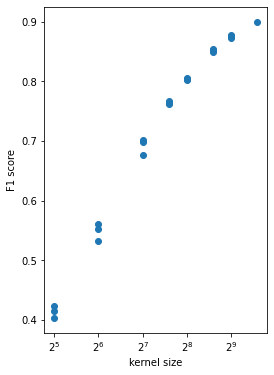

In [22]:
# plot the tradeoff between dimensionality and F1 score -(x scale is log base 2)
x = f1_scores['n_components']
y = f1_scores['f1-score']

plt.figure(figsize=(4,6))
plt.scatter(x,y)
plt.xscale('log',base=2)
# plt.yscale('log')
plt.ylabel('F1 score')
plt.xlabel('kernel size')
plt.show()
# this seems like it needs a high number of features to accurately predict.
# it might be interesting to see how the accuracy of models we use can impact 
# the quality of the 'flags' that we raise on the corpus 

# Now group and find agreements and disagreements between groups and 'gold' 
This process is largely analagous to what is done in conll_3.ipynb. Even though this problem is a token classification problem and the other one is an entity recognition one, by treating each token / part_of_speech pair as a seperate entity we are able to do much of the same grouping and comparisons

This process works as follows: 

1. Start with our set of predictions made by each model as a seperate dataframe
1. Grab a copy of the 'gold standard' tags from the corpus, and format it similarly to the predictions
1. Label each of the 'labels' dataframes with its original source
1. Combine the dataframes and use a single Pandas Groupby operation to find common token/Part-of-speech pairings, count the number of models in agreement, and determine if the pair is in the gold standard dataset 
1. Split into our 'in_gold' and 'not_in_gold' flagged subsets for human inspection 


In [23]:
# start with results dictionary dataframes... 
a_model = '256_1' # just took one at random
# copy res_dict because we will be modifying it
res_feats = {name: test_res_by_model[name].copy() for name in test_res_by_model.keys()}
res_feats[a_model].head()

,fold,doc_num,token_id,postag,postag_id,predicted_id,predicted_postag
raw_span,,,,,,,
"[0, 4): 'What'",test,0,1,PRON,8,12,ADV
"[5, 7): 'if'",test,0,2,SCONJ,10,3,NOUN
"[8, 14): 'Google'",test,0,3,PROPN,0,0,PROPN
"[15, 22): 'Morphed'",test,0,4,VERB,4,3,NOUN
"[23, 27): 'Into'",test,0,7,ADP,6,6,ADP


In [24]:
# now extract the 'in_gold' features and make them into a similar format as the results
gold_feats = res_feats[list(res_feats.keys())[0]][['fold','doc_num','token_id','postag','postag_id']].copy()
gold_feats['model'] = 'GOLD'
gold_feats['in_gold'] =True
gold_feats['gold_pos'] = gold_feats['postag']
gold_feats.head()

,fold,doc_num,token_id,postag,postag_id,model,in_gold,gold_pos
raw_span,,,,,,,,
"[0, 4): 'What'",test,0,1,PRON,8,GOLD,True,PRON
"[5, 7): 'if'",test,0,2,SCONJ,10,GOLD,True,SCONJ
"[8, 14): 'Google'",test,0,3,PROPN,0,GOLD,True,PROPN
"[15, 22): 'Morphed'",test,0,4,VERB,4,GOLD,True,VERB
"[23, 27): 'Into'",test,0,7,ADP,6,GOLD,True,ADP


In [25]:
# we will quickly want to modify them to label who created them, and remove the predicted cols
for model_name in res_feats.keys():
    res_feats[model_name]['model'] = model_name
    res_feats[model_name]['in_gold'] = False
    res_feats[model_name]['gold_pos'] = res_feats[model_name]['postag']
    res_feats[model_name].drop(columns = ['postag_id','postag'],inplace=True)
    res_feats[model_name].rename(columns= {'predicted_id':'postag_id','predicted_postag':'postag'},inplace=True)
res_feats[a_model].head()

,fold,doc_num,token_id,postag_id,postag,model,in_gold,gold_pos
raw_span,,,,,,,,
"[0, 4): 'What'",test,0,1,12,ADV,256_1,False,PRON
"[5, 7): 'if'",test,0,2,3,NOUN,256_1,False,SCONJ
"[8, 14): 'Google'",test,0,3,0,PROPN,256_1,False,PROPN
"[15, 22): 'Morphed'",test,0,4,3,NOUN,256_1,False,VERB
"[23, 27): 'Into'",test,0,7,6,ADP,256_1,False,ADP


In [26]:
# Now combine and collate 
res_feats['gold'] = gold_feats
result_feats_df= pd.concat(list(res_feats.values()))
result_feats_df.head()

,fold,doc_num,token_id,postag_id,postag,model,in_gold,gold_pos
raw_span,,,,,,,,
"[0, 4): 'What'",test,0,1,12,ADV,512_3,False,PRON
"[5, 7): 'if'",test,0,2,10,SCONJ,512_3,False,SCONJ
"[8, 14): 'Google'",test,0,3,0,PROPN,512_3,False,PROPN
"[15, 22): 'Morphed'",test,0,4,3,NOUN,512_3,False,VERB
"[23, 27): 'Into'",test,0,7,12,ADV,512_3,False,ADP


In [28]:
# add a count column so that only model-predicted results are tallied
result_feats_df['counts'] = 1
result_feats_df.loc[result_feats_df['in_gold'],'counts']=0

# create groupby aggregation dict 
aggby_firsts = ['fold','doc_num','token_id','gold_pos']
aggby= {'in_gold':'any','counts':'sum','model': lambda x: list(x)}
aggby.update({field: 'first' for field in aggby_firsts})
             
#now finally our groupby
grouped_feats = result_feats_df.groupby(['raw_span','postag'])\
                    .agg(aggby).sort_values(['counts','fold','doc_num','token_id'],ascending=False)\
                    .reset_index()
grouped_feats.head(10)

,raw_span,postag,in_gold,counts,model,fold,doc_num,token_id,gold_pos
0,"[226, 228): 'is'",AUX,True,22,"[512_3, 512_2, 512_1, 384_3, 384_2, 384_1, 256...",test,315,41,AUX
1,"[201, 204): 'the'",DET,True,22,"[512_3, 512_2, 512_1, 384_3, 384_2, 384_1, 256...",test,315,34,DET
2,"[133, 135): 'in'",ADP,True,22,"[512_3, 512_2, 512_1, 384_3, 384_2, 384_1, 256...",test,315,22,ADP
3,"[124, 127): 'the'",DET,True,22,"[512_3, 512_2, 512_1, 384_3, 384_2, 384_1, 256...",test,315,20,DET
4,"[77, 83): 'tissue'",NOUN,True,22,"[512_3, 512_2, 512_1, 384_3, 384_2, 384_1, 256...",test,315,14,NOUN
5,"[278, 282): 'Seth'",PROPN,True,22,"[512_3, 512_2, 512_1, 384_3, 384_2, 384_1, 256...",test,314,64,PROPN
6,"[241, 246): 'price'",NOUN,True,22,"[512_3, 512_2, 512_1, 384_3, 384_2, 384_1, 256...",test,314,54,NOUN
7,"[136, 139): 'was'",AUX,True,22,"[512_3, 512_2, 512_1, 384_3, 384_2, 384_1, 256...",test,314,32,AUX
8,"[122, 129): 'morning'",NOUN,True,22,"[512_3, 512_2, 512_1, 384_3, 384_2, 384_1, 256...",test,314,29,NOUN
9,"[78, 82): 'sink'",NOUN,True,22,"[512_3, 512_2, 512_1, 384_3, 384_2, 384_1, 256...",test,314,19,NOUN


In [29]:
# create the not_in_gold data subset, showing features that
# several models agree upon but disagree with the corpus label
not_in_gold = grouped_feats[~ grouped_feats['in_gold']]
not_in_gold.head(10)

,raw_span,postag,in_gold,counts,model,fold,doc_num,token_id,gold_pos
91,"[88, 96): 'trimmers'",NOUN,False,22,"[512_3, 512_2, 512_1, 384_3, 384_2, 384_1, 256...",test,303,27,PROPN
93,"[45, 49): 'rear'",NOUN,False,22,"[512_3, 512_2, 512_1, 384_3, 384_2, 384_1, 256...",test,303,17,ADJ
155,"[261, 262): '.'",X,False,22,"[512_3, 512_2, 512_1, 384_3, 384_2, 384_1, 256...",test,292,50,PUNCT
172,"[244, 252): 'computer'",NOUN,False,22,"[512_3, 512_2, 512_1, 384_3, 384_2, 384_1, 256...",test,290,50,ADJ
231,"[195, 200): 'front'",NOUN,False,22,"[512_3, 512_2, 512_1, 384_3, 384_2, 384_1, 256...",test,283,44,ADJ
249,"[203, 208): 'check'",NOUN,False,22,"[512_3, 512_2, 512_1, 384_3, 384_2, 384_1, 256...",test,280,41,VERB
257,"[213, 220): 'tmobile'",NOUN,False,22,"[512_3, 512_2, 512_1, 384_3, 384_2, 384_1, 256...",test,279,49,PROPN
261,"[168, 175): 'tmobile'",NOUN,False,22,"[512_3, 512_2, 512_1, 384_3, 384_2, 384_1, 256...",test,279,39,PROPN
263,"[71, 78): 'tmobile'",NOUN,False,22,"[512_3, 512_2, 512_1, 384_3, 384_2, 384_1, 256...",test,279,17,PROPN
267,"[6, 13): 'tmobile'",NOUN,False,22,"[512_3, 512_2, 512_1, 384_3, 384_2, 384_1, 256...",test,279,2,PROPN


In [30]:
# Display an example of a not-in-gold flagged token
# here, all 22 models agree that 'wikipedia.org' is a proper noun
# in this context, wheras the corpus lists it as 'X' type 
def display_span(span:tp.array.span):
    # use the inbuilt display features in SpanArray to display the token
    display(tp.SpanArray(span.target_text, [span.begin],[span.end]))
display_span(not_in_gold.reset_index().iloc[5]['raw_span'])


,begin,end,covered_text
0,203,208,check


In [31]:
# now generate in_gold, the set of tokens that are in the corpus
# but have low agreement between the models and the corpus
in_gold = grouped_feats[grouped_feats['in_gold']].sort_values('counts')# ascending
in_gold.head(10)

,raw_span,postag,in_gold,counts,model,fold,doc_num,token_id,gold_pos
83622,"[0, 4): 'What'",PRON,True,0,[GOLD],test,0,1,PRON
83093,"[109, 119): 'connecting'",VERB,True,0,[GOLD],test,102,25,VERB
83092,"[387, 390): ':-)'",SYM,True,0,[GOLD],test,102,88,SYM
83091,"[76, 80): 'with'",SCONJ,True,0,[GOLD],test,103,19,SCONJ
83090,"[394, 402): 'whatever'",DET,True,0,[GOLD],test,103,83,DET
83089,"[75, 80): 'where'",ADV,True,0,[GOLD],test,104,15,ADV
83088,"[208, 212): 'down'",ADV,True,0,[GOLD],test,104,39,ADV
83087,"[221, 232): 'considering'",VERB,True,0,[GOLD],test,104,44,VERB
83086,"[243, 249): 'search'",NOUN,True,0,[GOLD],test,104,48,NOUN
83085,"[416, 422): 'Google'",VERB,True,0,[GOLD],test,104,134,VERB


In [32]:
# display an example of an in-gold flagged token
# here the corpus states that the word 'must' is of the AUX
# part of speech, with 0 models in agreement with it. 
# here we also display the other predictions made by models to provide 
# context
targ_sp = in_gold.reset_index().iloc[8]['raw_span']
display_span(targ_sp)
grouped_feats 
grouped_feats[grouped_feats['raw_span']==targ_sp]

,begin,end,covered_text
0,243,249,search


,raw_span,postag,in_gold,counts,model,fold,doc_num,token_id,gold_pos
4603,"[243, 249): 'search'",X,False,21,"[512_3, 512_2, 512_1, 384_3, 384_2, 384_1, 256...",test,104,48,NOUN
64248,"[243, 249): 'search'",PRON,False,1,[32_2],test,104,48,NOUN
83086,"[243, 249): 'search'",NOUN,True,0,[GOLD],test,104,48,NOUN


,count
numModels,
22,118
21,108
20,100
19,114
18,137
17,139
16,121
15,153
14,199


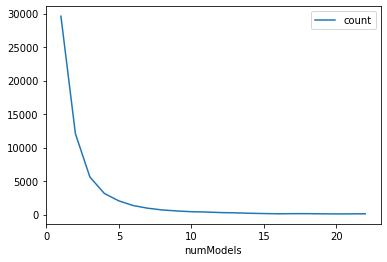

In [313]:
counts_ng = (
    not_in_gold.rename(columns={"counts": "numModels"})
    .groupby("numModels")
    .agg({"fold": "count"})
    .rename(columns={"fold": "count"})
    .sort_values("numModels", ascending=False)
)
counts_ng.plot()
counts_ng.head(10)

,no. elts
num_models,
0,801
1,387
2,332
3,299
4,303
5,326
6,330
7,370
8,418


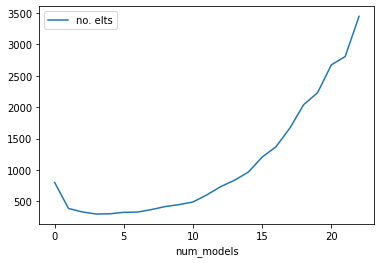

In [34]:
counts_ig = (
    in_gold.rename(columns={"counts": "num_models"})
    .groupby("num_models")
    .agg({"fold": "count"})
    .rename(columns={"fold": "no. elts"})
)
counts_ig.plot()
counts_ig.head(10)

In [35]:
# save a copy of our data to a file 
grouped_feats.to_csv(cached_models_dir +'v3_outputs.csv')